In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse.linalg
import scipy.sparse
import numba
import pypardiso




In [2]:
xmin, xmax = -1, 1
vmin, vmax = -3, 3
dx = 0.001
dv = 0.01
Nx = int((xmax - xmin) / dx)
Nv = int((vmax - vmin) / dv)
kbt = .1
gamma = 5

Ncol = Nx - 1
Nrow = Nv + 1
x = np.linspace(xmin, xmax, Nx + 1)
v = np.linspace(vmin, vmax, Nv + 1)

if Ncol == Nx - 1:
    xcal = x[1:-1]
else:
    xcal = x

if Nrow == Nv - 1:
    vcal = v[1:-1]
else:
    vcal = v


X, V = np.meshgrid(xcal, vcal)
# print(X.shape, V)

points = np.array([X.reshape(-1), V.reshape(-1)]).T
'''
c = np.arange(len(points))
plt.scatter(points[:, 0], points[:, 1], c=c)
plt.colorbar()
plt.show()
'''
N_matrix = Nrow * Ncol

dU = 4 * (points[:, 0]**2 - 1) * points[:, 0]
# print(dU.shape)


b_vec = np.zeros(N_matrix)

# dilichlet boundary
b_vec[(Ncol - 1)::Ncol] = -1 / dx * points[(Ncol - 1)::Ncol, 1] / 2

'''
c = np.arange(len(points))
plt.scatter(points[:, 0], points[:, 1], c=c[:])
plt.colorbar()
plt.show()
'''
# kbt = 1, gamma = 1, epsilon = .2
epsilon = 1e-11

b_vec[(Ncol - 1)::Ncol] -= epsilon * gamma * kbt / dx**2
@numba.njit
def make_matrix(Nrow,Ncol,points,dU,b_vec,gamma,kbt):
    data = np.empty(5*Nrow*Ncol,dtype=np.float64)
    row = np.empty(5*Nrow*Ncol,dtype=np.int32)
    col = np.empty(5*Nrow*Ncol,dtype=np.int32)
    length = 0
    for i in range(Nrow):
        for j in range(Ncol):
            idx = j + i * Ncol

            itself_repo = 0

            if j != Ncol - 1:
                row[length]=idx
                col[length]=idx+1
                data[length]=points[idx, 1] / dx / \
                    2 + epsilon * gamma * kbt / dx**2
                length += 1

            if j != 0:
                row[length]=idx
                col[length]=idx-1
                data[length]=-points[idx, 1] / \
                    dx / 2 + epsilon * gamma * kbt / dx**2
                length += 1


            if i != Nrow - 1:
                row[length]=idx
                col[length]=idx + Ncol
                data[length]=(-dU[idx] - gamma *
                                    points[idx, 1]) / (2 * dv) + gamma * kbt / dv**2
                length += 1


            else:
                itself_repo += (-dU[idx] - gamma * points[idx, 1]
                                ) / (2 * dv) + gamma * kbt / dv**2

            if i != 0:
                row[length]=idx
                col[length]=idx - Ncol
                data[length]=(+dU[idx] + gamma *
                                    points[idx, 1]) / (2 * dv) + gamma * kbt / dv**2
                length += 1
            else:
                itself_repo += (+dU[idx] + gamma * points[idx, 1]
                                ) / (2 * dv) + gamma * kbt / dv**2

            row[length]=idx
            col[length]=idx 
            data[length]=-gamma * kbt * 2 / dv**2 - \
                epsilon * gamma * kbt * 2 / dx**2 + itself_repo
            length += 1
    return data,row,col,length
data,row,col,length = make_matrix(Nrow,Ncol,points,dU,b_vec,gamma,kbt)
A = scipy.sparse.csr_array( (data[:length],(row[:length],col[:length])),shape=(N_matrix,N_matrix))
print(f"Solving linear equation with dimension {A.shape}!")

q = pypardiso.spsolve(A, b_vec)
Q = q.reshape(X.shape)
print("Completed!")

Solving linear equation with dimension (1201399, 1201399)!
Completed!


In [131]:
# A_inv = scipy.sparse.linalg.inv(A)

In [132]:
#u, s, vt = scipy.sparse.linalg.svds(A, k=1)
#u1, s1, vt1 = scipy.sparse.linalg.svds(A_inv, k=1)

In [133]:
#s[0]*s1[0]

In [173]:
A = scipy.sparse.lil_matrix((Ncol, Ncol))
dU1 =  4 * (xcal**2 - 1) * xcal
b_vec = np.zeros_like(xcal)
b_vec[-1] = dU1[-1]/2/dx-kbt/dx**2
for j in range(Ncol):
    if j != Ncol - 1:
        A[j, j + 1] = -dU1[j] / dx / 2 + kbt / dx**2

    if j != 0:
        A[j, j - 1] = dU1[j] / dx /2+ kbt / dx**2

    A[j,j] = -kbt *2/dx**2

q0 = pypardiso.spsolve(A.tocsr(), b_vec)


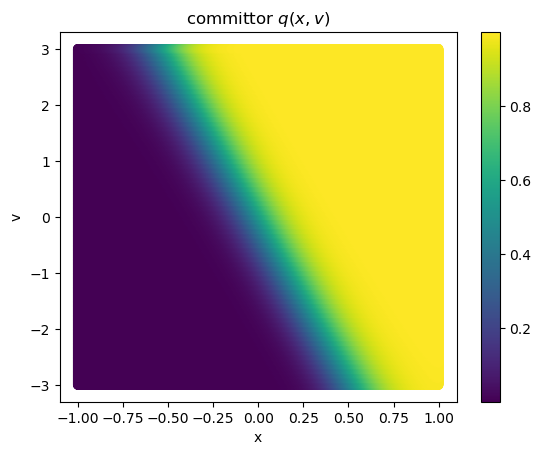

In [3]:
plt.scatter(points[:, 0], points[:, 1], c=q)
plt.title('committor $q(x,v)$')
plt.xlabel('x')
plt.ylabel('v')
plt.colorbar()
plt.show()


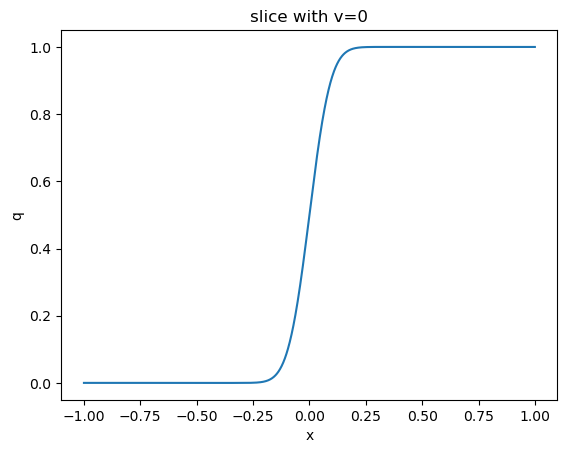

In [181]:
vslice = 0
plt.plot(xcal, Q[int((vslice-vmin)/dv), :])
plt.xlabel('x')
plt.ylabel('q')
plt.title(f'slice with v={vslice}')
plt.show()

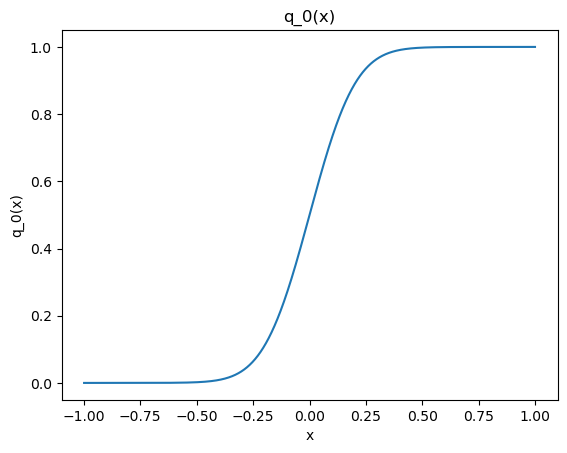

In [175]:
plt.plot(xcal,q0)
plt.xlabel('x')
plt.ylabel('q_0(x)')
plt.title('q_0(x)')
plt.show()

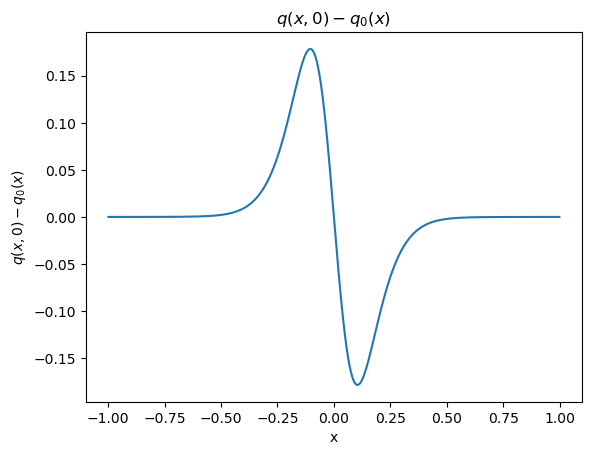

In [182]:
plt.plot(xcal,q0-Q[int((0-vmin)/dv), :])
plt.xlabel('x')
plt.ylabel('$q(x,0)-q_0(x)$')
plt.title('$q(x,0)-q_0(x)$')
plt.show()

In [4]:
r = np.concatenate((points,q.reshape((len(q),1))),axis = 1)

In [5]:
r

array([[-9.99000000e-01, -3.00000000e+00,  1.06779907e-08],
       [-9.98000000e-01, -3.00000000e+00,  3.50178389e-10],
       [-9.97000000e-01, -3.00000000e+00,  1.06910328e-08],
       ...,
       [ 9.97000000e-01,  3.00000000e+00,  9.99999988e-01],
       [ 9.98000000e-01,  3.00000000e+00,  1.00000000e+00],
       [ 9.99000000e-01,  3.00000000e+00,  9.99999988e-01]])

In [ ]:
np.savetxt('fd_kbt.1_gamma.1.txt',r)